# Joblib distributed [1/2] - Local Mode

A very simple compute intensive function.

In [8]:
def compute_intensive():
    timestamp = time()
    # simulate a heavy computation
    total = 0
    for i in range(int(2e7)):
        total += 1
    return (os.getpid(), timestamp)

An function without any computation, representing async or IO tasks.

In [10]:
import os
from time import time, sleep

SLEEP_DURATION = 1

def time_sleep():
    timestamp = time()
    # simulate a heavy computation
    sleep(SLEEP_DURATION)
    return (os.getpid(), timestamp)

Next, we define a joblib parallelization on 80 items.

In [22]:
import numpy as np
from joblib import Parallel, delayed
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")


def bench(all_n_jobs, func, backend):
    durations = []
    for n_jobs in all_n_jobs:
        tic = time()
        out = Parallel(backend=backend, n_jobs=n_jobs)(
            delayed(func)()
            for i in range(80)
        )
        toc = time()
        durations.append(toc - tic)
    return durations


def plot_speedup_combined(all_n_jobs, results):
    
    fig = plt.figure(dpi=90)
    ax = sns.lineplot(x=all_n_jobs, y=all_n_jobs, color="black")
    
    for result in results:
        func, backend, durations = list(result.values())
        speedup = durations[0] / durations
        label = f"{backend} - {func}"
        sns.lineplot(x=all_n_jobs, y=speedup, marker="o", ax=ax, label=label)
    
    ax.set(xscale="log", yscale="log");    
    ax.set_xticks(all_n_jobs);
    ax.set_xticklabels(all_n_jobs);
    ax.set_xlabel("number of jobs")
    ax.set_ylabel("speedup")
    ax.set_title("Speedup by backend and task type")
    plt.legend();

Let's run it for various `n_jobs`:

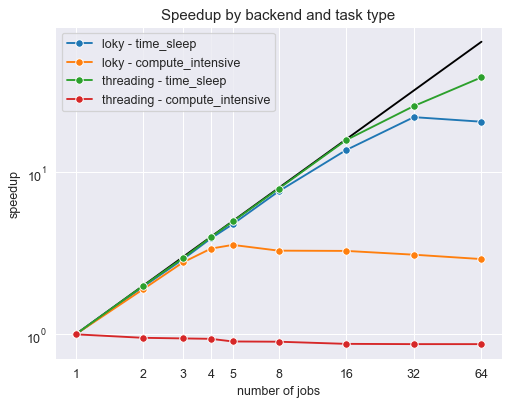

In [23]:
all_n_jobs = np.array([1, 2, 3, 4, 5, 8, 16, 32, 64])
results = []
for backend in ["loky", "threading"]:
    for func in [time_sleep, compute_intensive]:
        durations = bench(all_n_jobs, func, backend)
        title = f"{backend} - {func.__name__}"
        results.append(
            dict(
                func=func.__name__,
                backend=backend,
                durations=np.array(durations),
            )
        )
plot_speedup_combined(all_n_jobs, results)